## **Project Title**: Forecasting German Inflation using a Exponential smoothing and  ARIMA models

### **Project Description**
In this notebook, we predict German inflation rate using a  Exponential smoothing and simple ARIMA models. 

Inflation is the general increase in the overall price level of goods and services bought by households (citizens). It is measured as the average price change over a given period of time for a basket of goods and services that are purchased in the economy. The inflation rate is proxied by the Harmonised Index of Consumer Prices (HICP)(percentage change) from January 1996 to May 2024.
 In the euro area, it is measured as changes in the Harmonised Index of Consumer Prices (HICP) compared with the same period one year earlier (“year-on-year” changes). The HICP is broken down following the European classification of individual consumption according to purpose (ECOICOP) and by goods and services aggregates derived from it.

The link to the time series dataset can be found here <a href= "https://data.ecb.europa.eu/data/datasets/ICP/ICP.M.DE.N.000000.4.ANR">Click here</a>




*We begin by importing all the python libraries used for this exercise.  The main library used for exploring the data and plots is pandas. Statsmodels library will be used for the econometric/statistical modelling*

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import mse, rmse

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL


import warnings
warnings.filterwarnings("ignore")



#### Data import and cleaning

In [4]:
df = pd.read_csv('HICP_Ger.csv', sep='\\s+|,')
df.head()

,"""DATE","""""TIME","PERIOD""""","""""HICP",""""""""
0,"""1996-01-31","""""1996Jan""""","""""0.5""""""",NaN,NaN
1,"""1996-02-29","""""1996Feb""""","""""0.7""""""",NaN,NaN
2,"""1996-03-31","""""1996Mar""""","""""0.8""""""",NaN,NaN
3,"""1996-04-30","""""1996Apr""""","""""0.5""""""",NaN,NaN
4,"""1996-05-31","""""1996May""""","""""0.7""""""",NaN,NaN


In [5]:
columns_to_drop = [1, 3, 4]
df.drop(df.columns[columns_to_drop], axis=1, inplace=True)
        

In [6]:
df.columns = df.columns.str.replace('"', '')
df.head()

,DATE,PERIOD
0,"""1996-01-31","""""0.5"""""""
1,"""1996-02-29","""""0.7"""""""
2,"""1996-03-31","""""0.8"""""""
3,"""1996-04-30","""""0.5"""""""
4,"""1996-05-31","""""0.7"""""""


In [7]:
df.rename(columns = {"PERIOD":"HICP"}, inplace = True)

In [8]:
for cols in df:
    df[cols] = df[cols].str.strip('"')

df.head()

,DATE,HICP
0,1996-01-31,0.5
1,1996-02-29,0.7
2,1996-03-31,0.8
3,1996-04-30,0.5
4,1996-05-31,0.7




*Next, the dataset is converted so that pandas can recognize data as time series. The dates are indexed as timestamps specified in monthly frequency*

In [9]:
df.set_index("DATE", inplace = True)

In [10]:

df.index = pd.to_datetime(df.index)


In [11]:
df.index.freq = "M"
df.index

DatetimeIndex(['1996-01-31', '1996-02-29', '1996-03-31', '1996-04-30',
               '1996-05-31', '1996-06-30', '1996-07-31', '1996-08-31',
               '1996-09-30', '1996-10-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', name='DATE', length=341, freq='M')

In [12]:
df['HICP'] = pd.to_numeric(df['HICP'])


*Data (series) is plotted to visualize the behaviour/pattern. From the below plot, we do not have strong evidence of seasonality in the series. Moreover, the series looks pretty stable except for periods after 2019*

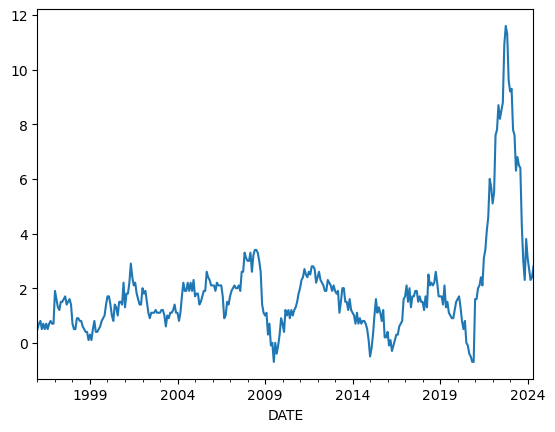

In [13]:
df['HICP'].plot();



 *To verify the claim of non-seasonality, we decompose the series further using ETS Decomposition. ETS stands for Error-Trend-Seasonality method used specifically for time series decompositon. Here, we implement seasonal decomposition using classical approach where the series is decomposed via moving averages.*


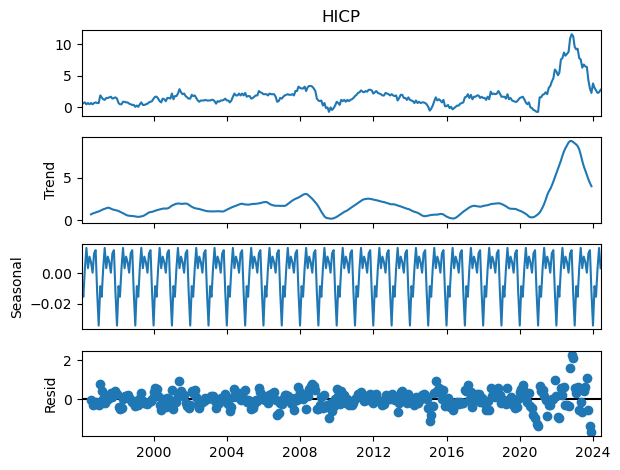

In [14]:


decomp = seasonal_decompose(df['HICP'], model='additive')  
decomp.plot();

*From the above plots, it can be observed that the magnitude of the seasonal swings (third row plot) is rather low - ranging between zero and negative 2. Hence it confirms the assertion regarding lack of evidence of seasonality in the data*

*Alternatively, one could also use the STL (Seasonal and trend decomposition using LOESS) in statsmodel to implement the decomposition of the series. LOESS refers to Locally Estimated Scatterplot Smoothing, a flexible non-parametric regression technique. SLT decomposition is demonstrated below. The story does not change that much - the magnitude of the seasonal swing is pretty low*


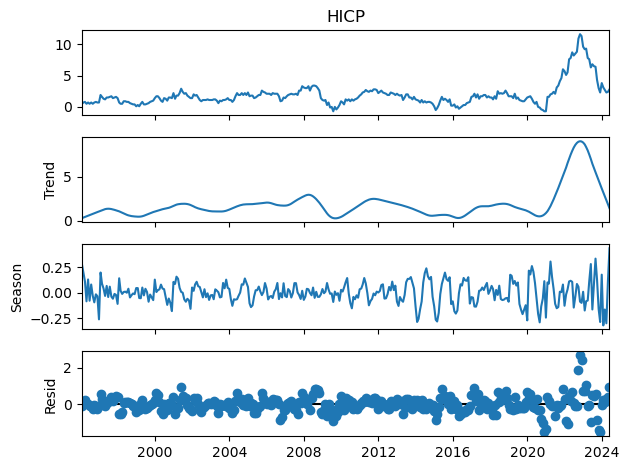

In [15]:
stl_decomp = STL(df['HICP'], period=12).fit()
stl_decomp.plot();



### Checking for stationarity
*Augmented Dickey fuller test and the Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test are used to check if the series is stationary. From the above plot, it can be noticed that series appears not to have a constant mean and hence, likely to be non-stationary. It looks like a random walk process. Nevertheless a formal econometric test is conducted to confirm stationarity. The below function implements the test*.

#### Augmented dickey fuller (ADF) test

In [16]:

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df["HICP"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.270448
p-value                   0.016252
# lags used              14.000000
# observations          326.000000
critical value (1%)      -3.450569
critical value (5%)      -2.870447
critical value (10%)     -2.571515
Reject the null hypothesis
Data has no unit root and is stationary


 *The outcome of ADF test indicates that the series is stationary. Due to the fact the the plot of the series does not clearly show stationarity, we employ the KPSS test to double check stationarity (an alternative stationarity test)*

####  Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test

In [18]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    if kpsstest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has  unit root and is therefore non-stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has no unit root and is stationary")

In [19]:
kpss_test(df["HICP"])

Results of KPSS Test:
Test Statistic            0.597286
p-value                   0.022883
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis
Data has  unit root and is therefore non-stationary


*Above results from the KPSS indicates that the series is non-stationary. This has satisfied our curiosity since the actual plot does not point toward the direction of a stationary series.*

*Next, the difference of the series is computed and stationarity is tested in the below. The results below confirm stationarity of the first difference of the series. Since the series is differenced only once to attain stationarity, the intergratedness of the ARIMA model is considered to be 1*

In [20]:
df["HICP_diff"] = diff(df["HICP"], k_diff=1)

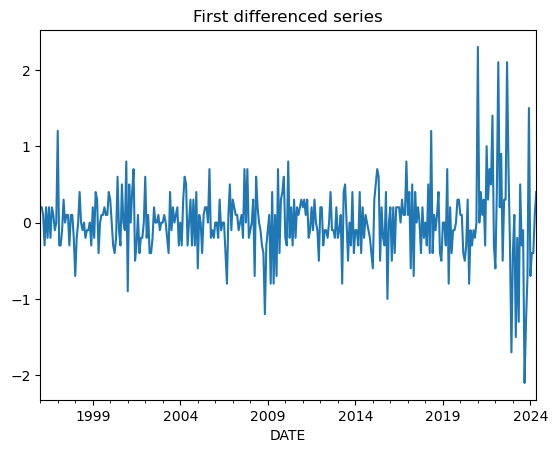

In [21]:
df["HICP_diff"].plot(title = "First differenced series");

In [22]:
df["HICP_diff"]

DATE
1996-01-31    NaN
1996-02-29    0.2
1996-03-31    0.1
1996-04-30   -0.3
1996-05-31    0.2
             ... 
2024-01-31   -0.7
2024-02-29   -0.4
2024-03-31   -0.4
2024-04-30    0.1
2024-05-31    0.4
Freq: M, Name: HICP_diff, Length: 341, dtype: float64

*Above differenced plot appears to be stable and exhibits a constant mean hovering around zero. Nevertheless it appears the variability in the last section of the data (from 2019) is greater than the earlier part of the data - due to COVID-effects etc.*


*Next, the KPSS test for the differenced data is diplayed below. This test is computed just to ensure the series is integrated of order 1 (I(1)) - implying stationarity at first difference*

In [23]:
kpss_test(df["HICP_diff"][1:])

Results of KPSS Test:
Test Statistic           0.037781
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Fail to reject the null hypothesis
Data has no unit root and is stationary


#### **Train-test split**
*To build a model suitable for predicting into the future, we firstly divide the data into train and test sets. The trained data would be used for building the model for forecasting and test data would be used for model evaluation purposes. For the test data, we use the last 12 months since the idea is to predict inflation for the next year (12 months).*

*The train set consist of the first 329 months, whilst the test set consist of the last 12 months of the data. This is because we would like to forecast inflation for the next 12 moonths(1 year)*

In [24]:
df_train = df.iloc[:329]
df_test  = df.iloc[329:]


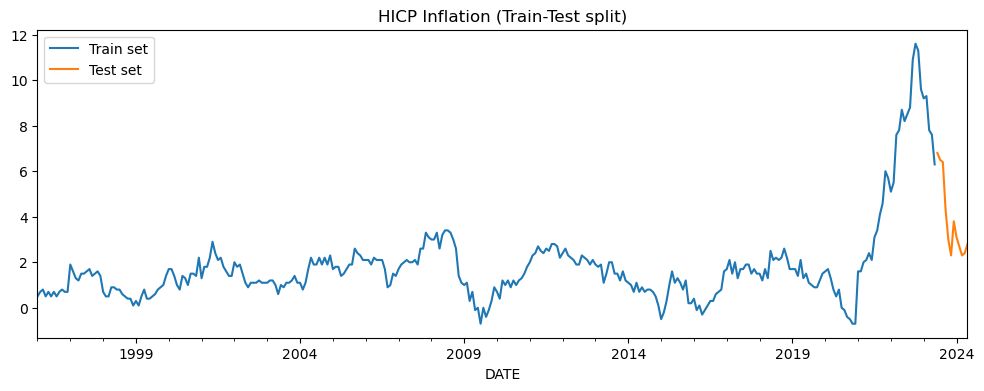

In [25]:
df_train["HICP"].plot(legend = True, label = "Train set",figsize=(12,4))
df_test["HICP"].plot(legend = True, label = "Test set", title = "HICP Inflation (Train-Test split)");


## Exponential smoothing 
*Exponential smoothing (ES) models are one of the simple and popular forcasting models. The ES produces forecast values that are weighted averages of past values (observations), with weights decaying exponentially as the observations gets older. This implies that more recent observations are assigned  higher relative weights as compared to older observations.*

 Three main types of exponential smoothing  methods
*  ***Simple exponential smoothing**: This model constitutes the simplest of the exponential smoothing approaches. It is particularly suitable for for forecasting time series datasets that does **not** exhibit any clear trend or seasonal patterns.*

* ***Holt exponential smoothing** : Also known as double exponential smoothing, this model is an extension of the simple exponential smoothing in order to allow for forecasting timeseries datasets with a trend. This is made possible by allowing for the modelling of two smoothing equations - one for the level of the seies and the other to account for the trend.*

* ***Holt winters eponential smoothing**: Thriple exponential smoothing, here the model is extended further to incorporate seasonality. Hence the model captures trend and seasonality simultaneously in the dataset. The model has three equations namely, one for the level, the other for trend and finally for the seasonal component.*

*It is also important to note that both the Holt and Holt-Winters smoothing models allows for  variations in the trend and seasonal components respectively (additive and multiplicative variations). The additive variation is recommended when the seasonal variation (or trend) are roughly constant. On the other hand the multiplicative variation is recommended when the variations in the seasonal component are changing proportional to the level of the series.*

### Simple Exponential smoothing

In [26]:
mod_fit_ses = SimpleExpSmoothing(df_train["HICP"]).fit(optimized=True)

In [27]:
test_predictions_ses = mod_fit_ses.forecast(12).rename('Simple Exponential Smoothing')

In [28]:
pd.concat([df_test['HICP'],test_predictions_ses], axis=1)

,HICP,Simple Exponential Smoothing
2023-06-30,6.8,6.341099
2023-07-31,6.5,6.341099
2023-08-31,6.4,6.341099
2023-09-30,4.3,6.341099
2023-10-31,3.0,6.341099
2023-11-30,2.3,6.341099
2023-12-31,3.8,6.341099
2024-01-31,3.1,6.341099
2024-02-29,2.7,6.341099
2024-03-31,2.3,6.341099


In [29]:
MSE_ses = mse(df_test['HICP'],test_predictions_ses)
RMSE_ses = rmse(df_test['HICP'],test_predictions_ses)
print("")
print(f"The Simple Exponential Smoothing MSE is {MSE_ses:.3f}")
print("")



The Simple Exponential Smoothing MSE is 8.877



### Holt Exponential Smoothing
*In what follows, we extend further to allow for a trend in the series (Holt's exponential smoothing). Even though the series does not clearly depict any particular trend, we consider this model for demonstrative and comparision purposes. We consider an additive variant of the trend. Since the series does not exhibit strong evidence of seasonality, we do not consider the thriple exponential smoothing or Honlt-winters smoothing approach* 

*From the below, the model is fitted to a training set and forecasted  12 months ahead. The forecasted data is then compared to the test dataset*

In [30]:
mod_fit_hw = ExponentialSmoothing(df_train["HICP"], trend='additive').fit()

In [31]:
test_predictions_hw = mod_fit_hw.forecast(12).rename('Holt Exponential Smoothing')

*Next we use a grid search to select the optimal alpha level via cross-validation. The below function executes the grid search*

In [32]:
import numpy as np
alphas = np.linspace(0.01, 0.99, num=50)
best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    model = ExponentialSmoothing(df_train["HICP"],trend='additive').fit(smoothing_level=alpha)
    forecast = model.forecast(steps=len(df_test["HICP"]))
    Mse = mse(df_test["HICP"], forecast)
    if  Mse < best_mse:
        best_mse = Mse
        best_alpha = alpha



In [33]:
# Forecast future values
final_model = ExponentialSmoothing(df_train["HICP"],trend='additive').fit(smoothing_level=best_alpha)
future_forecast = final_model.forecast(steps=12).rename("Holts Exponential smoothing (Tuning)")

#### Model Evaluation

In [34]:
MSE_hw = mse(df_test['HICP'],test_predictions_hw)

RMSE_hw_t = mse(df_test["HICP"],future_forecast)

print("")
print(f"The Holt's Exponential MSE is {MSE_hw:.3f}")
print("")
print(f"The The Holt's Exponential MSE with parameter tuning is {RMSE_hw_t:.3f}")
print("")


The Holt's Exponential MSE is 9.653

The The Holt's Exponential MSE with parameter tuning is 1.201




#### Plot of model predictions
*Below plot depicts the model predictions using simple exponential smooting and Holt's exponential smoothing compared  against the test set.*

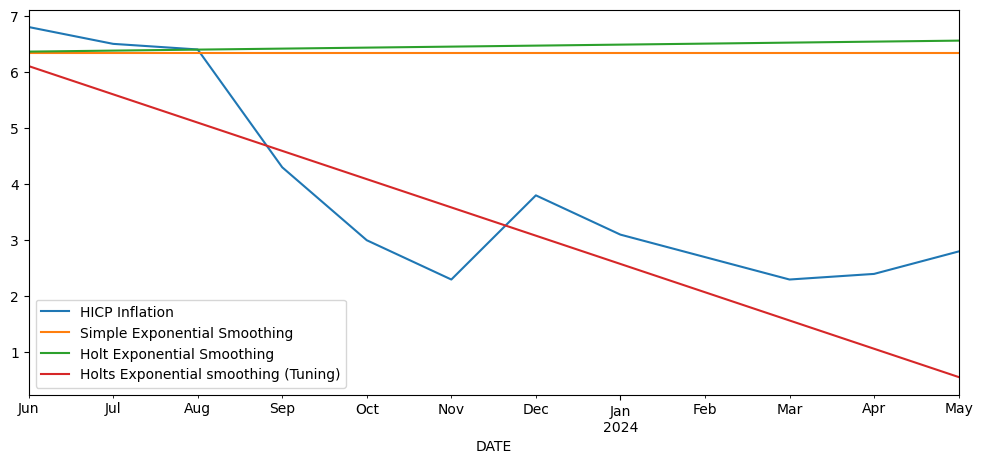

In [35]:
df_test["HICP"].plot(legend=True, figsize=(12,5), label="HICP Inflation")
test_predictions_ses.plot(legend=True)
test_predictions_hw.plot(legend=True)
future_forecast.plot(legend=True);

*Form the above it can be noted that among the three models, the Exponential smoothing (with parameter tuding tracks the actual HICP inflation quite well as compared to the other two modes. However, the prediction declines and approaches zero with time. Hence, forecasting using this model for a longer time frame would not be very convincing*

### Forecasting into the future
*Next, we provide 12 months prediction into the future using the two  models. Here we use the full data set for building the models. with this forecast we do not have future values or any test data.*

In [36]:
mod_train_hw = ExponentialSmoothing(df["HICP"],trend='additive').fit()
mod_train_hw_t = ExponentialSmoothing(df["HICP"],trend='additive').fit(smoothing_level=best_alpha)
mod_train_ses = SimpleExpSmoothing(df["HICP"]).fit()

In [61]:
mod_pred_hw = mod_train_hw.forecast(12).rename("Holt Exponential Smoothing")
mod_pred_hw_t = mod_train_hw_t.forecast(12).rename("Holt Exponential Smoothing (With hyper tuning)")
mod_pred_ses = mod_train_ses.forecast(12).rename("Simple Exponential Smoothing")

In [62]:
pd.concat([mod_pred_hw,mod_pred_hw_t,mod_pred_ses],axis=1)

,Holt Exponential Smoothing,Holt Exponential Smoothing (With hyper tuning),Simple Exponential Smoothing
2024-06-30,2.801880,2.335262,2.795101
2024-07-31,2.808626,2.121988,2.795101
2024-08-31,2.815371,1.908713,2.795101
2024-09-30,2.822117,1.695439,2.795101
2024-10-31,2.828862,1.482164,2.795101
2024-11-30,2.835608,1.268889,2.795101
2024-12-31,2.842353,1.055615,2.795101
2025-01-31,2.849099,0.842340,2.795101
2025-02-28,2.855845,0.629066,2.795101
2025-03-31,2.862590,0.415791,2.795101


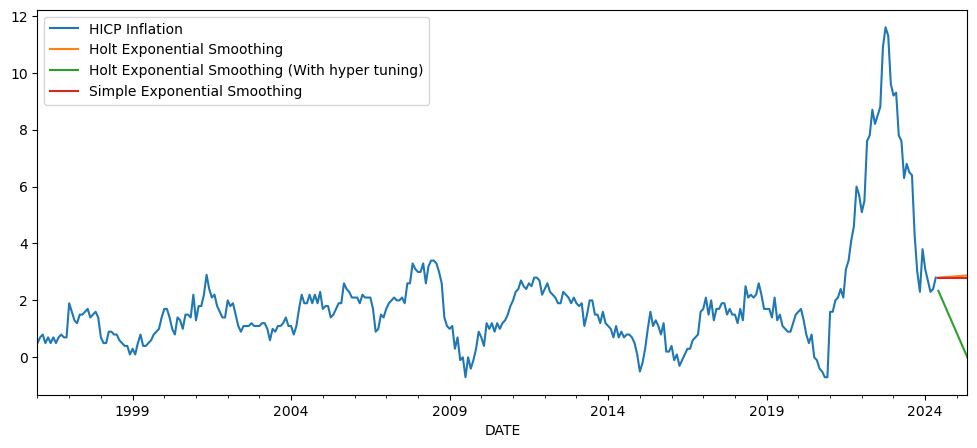

In [63]:
df['HICP'].plot(legend=True, figsize=(12,5), label = "HICP Inflation")
mod_pred_hw.plot(legend = True);
mod_pred_hw_t.plot(legend = True);
mod_pred_ses.plot(legend = True);

*It can be observed that the predictions from the simple Exponential smoothing and Holt exponential smoothing are pretty similar. Predicted values for the Holt model (with smoohing parameter) is downward sloping straight line approaching zero which may not appear to be a realistic prediction.* 

*Next, we will take a look at ARIMA models and how that compares to exponential smoothing*


### The ARIMA Model

ARIMA stands for Autoregressive Integrated Moving Average and is made up of a combination of three models:
* *AR(p): Autoregressive model of order P - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period*
* *I(d):  Integration of order d- uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary*
* *MA(q):  Moving Average model of order q - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.*

*More information regarding arima models can be obtained from* <a href= "https://people.duke.edu/~rnau/411home.htm">Click here</a>


#### Selecting the optimal ARIMA model

*To proceed with modelling, it is important to ascertain the lags length for the AR and MA components of the ARIMA model. The Auto_arima function from the pmdarima library is used for the selection of the optimal lags. Alternatively one can use a manual process by visualizing the ACF and PACF plots. However, the interpretation of the plots can sometimes be far from straight-forward.  In this exercise, we will firstly use the automatic process (auto_arima) to select the optimal ARIMA model. Subsequently, the ACF and PACF plots will be examined manually.*


In [39]:
auto_arima(df["HICP"],  trace=True,stepwise=True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=448.100, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=455.229, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=457.147, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=457.164, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=453.300, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=446.564, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=454.004, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.488, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=448.003, Time=0.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=449.548, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=449.974, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=444.633, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=452.066, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=450.569, 

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

*ARIMA(1,1,2) is chosen as the optimal model since it has the minimum information criteria values (AIC)*

 *As already mentioned, one can look at the PACF and ACF plots to manually choose the best ARIMA model. In what follows below, we will look at each plot*

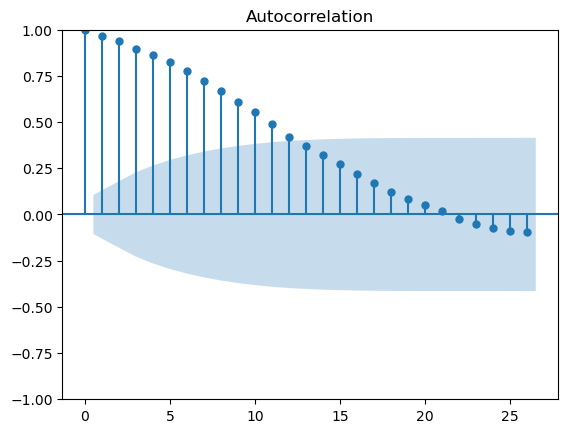

In [40]:
plot_acf(df["HICP"]);

 *The above auto correlation plot indicate slow decaying of the lag lenghts. Note that the acf plots is used to determined the number of lags for the moving average part of the ARIMA. From the above plot, the suitable choice for the MA part is roughly 12 since the plot shows a cut-off from 12 lags.*

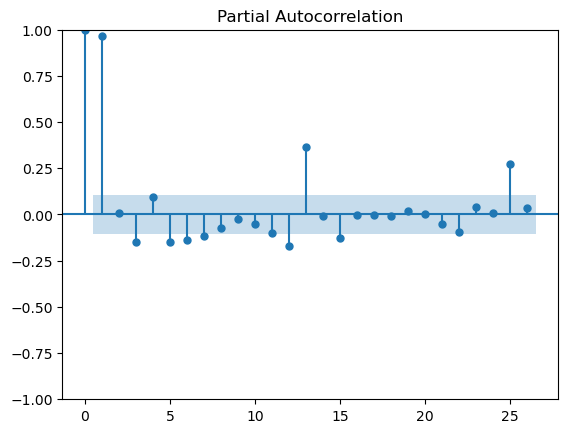

In [41]:
plot_pacf(df["HICP"]);

 *The above  plot indicates that the pacf cuts off after lag 1 (since it is out of the significance zone). Hence an AR-1 is appropriate for the ARIMA. Of course there are few lags which are out of the bounds but that is not problematic since those lags do not follow in a chronological order. In conclusion, ARIMA(1,1,12) is preferred if we follow the reulst from the ACF and PACF plot.*

 *In what follows next, we will consider both models.  The idea is to compare the predictions/performance of the two models*

* ARIMA(1,1,2) - results from the automatic lag selection. 
* ARIMA(1,1, 12)) - results from manual lag selection.


**ARIMA(1,1,2)**

*Firstly, the ARIMA(1,1,2) model is fitted*

In [42]:
arima_mod = ARIMA(df_train["HICP"], order=(1,1,2)).fit()

In [43]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   HICP   No. Observations:                  329
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -193.983
Date:                Wed, 03 Jul 2024   AIC                            395.965
Time:                        14:49:12   BIC                            411.137
Sample:                    01-31-1996   HQIC                           402.018
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6505      0.153     -4.248      0.000      -0.951      -0.350
ma.L1          0.6344      0.140      4.521      0.000       0.359       0.909
ma.L2          0.1361      0.060      2.283      0.022       0.019       0.253
sigma2         0.1910      0.008     22.817      0.000       0.175       0.207
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               423.57
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""




*The trained model is used  to make prediction for the last 12 months. After that the actual inflation (HICP) for the last 12 months is compared to the predicted data to see how close the two series are (model evaluation).*

In [44]:
arima_test_pred = arima_mod.get_forecast(steps=12)

**ARIMA(1,1,12)**

 *Next the ARIMA(1,1,12) is also fitted after which the two models are compared*

In [45]:
arima_mod_12 = ARIMA(df_train["HICP"], order=(1,1,12)).fit()
arima_test_pred_12 = arima_mod_12.get_forecast(steps=12)



##### *Actual HICP(test data) is compared against ARIMA predicted HICP*

In [46]:
 pd.concat([df_test["HICP"].rename("Actual"), 
            round(arima_test_pred.predicted_mean.rename("Predicted-ARIMA(1,1,2)"),2),
           round(arima_test_pred_12.predicted_mean.rename("Predicted-ARIMA(1,1,12)"),2)], axis = 1)

,Actual,"Predicted-ARIMA(1,1,2)","Predicted-ARIMA(1,1,12)"
2023-06-30,6.8,6.43,6.44
2023-07-31,6.5,6.20,6.40
2023-08-31,6.4,6.35,6.17
2023-09-30,4.3,6.25,5.02
2023-10-31,3.0,6.32,4.37
2023-11-30,2.3,6.27,4.08
2023-12-31,3.8,6.30,5.14
2024-01-31,3.1,6.28,5.12
2024-02-29,2.7,6.30,4.92
2024-03-31,2.3,6.29,5.35


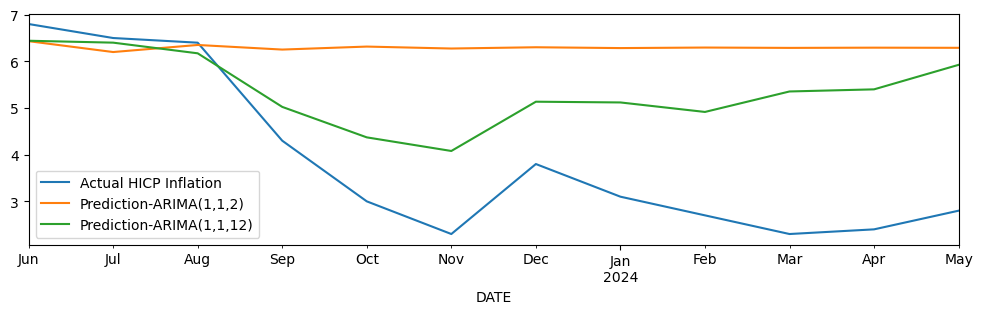

In [47]:
df_test["HICP"].plot(legend=True, label = "Actual HICP Inflation",figsize=(12,3));
arima_test_pred.predicted_mean.plot(legend=True, label="Prediction-ARIMA(1,1,2)");
arima_test_pred_12.predicted_mean.plot(legend=True, label="Prediction-ARIMA(1,1,12)");

 *From the above graph, it can be observed that the ARIMA(1,1,12) does a better job of tracking the actual HICP  quite well as compared to  the ARIMA(1,1,2). Also it can be noticed that three series are closest in the first three months, after which the the difference between them gets wider. Our prediction is most effective in the initial three months*


#### Model evaluation 
*Regarding the model evaluation, the mean square is computed using the test data. In order words we would like to evaluate the models based on the unseen test data*

In [48]:

arima_mse = mse(df_test["HICP"],arima_test_pred.predicted_mean)
arima_rmse = rmse(df_test["HICP"],arima_test_pred.predicted_mean)

arima_mse_12 = mse(df_test["HICP"],arima_test_pred_12.predicted_mean)
arima_rmse_12 = rmse(df_test["HICP"],arima_test_pred_12.predicted_mean)

print("")

print(f"The MSE for ARIMA(1,1,2) is {arima_mse:.3f}")

print("")

print(f"The MSE for ARIMA(1,1,12) is {arima_mse_12:.3f}")



The MSE for ARIMA(1,1,2) is 8.618

The MSE for ARIMA(1,1,12) is 3.719


*It can be observed ARIMA(1,1,12) is the superior of the two models since it has the minimal MSE and RMSE. Also based on the model evaluation, we can conclude that for this dataset, the ARIMA model performs better than the EXponential smoothing class of models*

#### Prediction in to the future 
*Next we used both models to train the full data and then predict 12 months into the future. In this case we do not have any test data to compare our results with. We will build a model with the full dataset and then predict into the future*


*We will start by training the model with ARIMA(1,1,2)*


In [49]:
full_arima_train = ARIMA(df["HICP"], order=(1,1,2)).fit()

In [50]:
print(full_arima_train.summary())

                               SARIMAX Results                                
Dep. Variable:                   HICP   No. Observations:                  341
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -218.316
Date:                Wed, 03 Jul 2024   AIC                            444.633
Time:                        14:49:17   BIC                            459.949
Sample:                    01-31-1996   HQIC                           450.735
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7206      0.099     -7.271      0.000      -0.915      -0.526
ma.L1          0.7459      0.104      7.141      0.000       0.541       0.951
ma.L2          0.1670      0.055      3.060      0.0

 *Next, we visualize the residuals in order to look at the various residual diagnostics test. By this we are able to judge if the residuals conform to some of the underlying assumptions of the model.*
 
 **Below depicts some residual diagnostics of ARIMA(1,1,2) model**

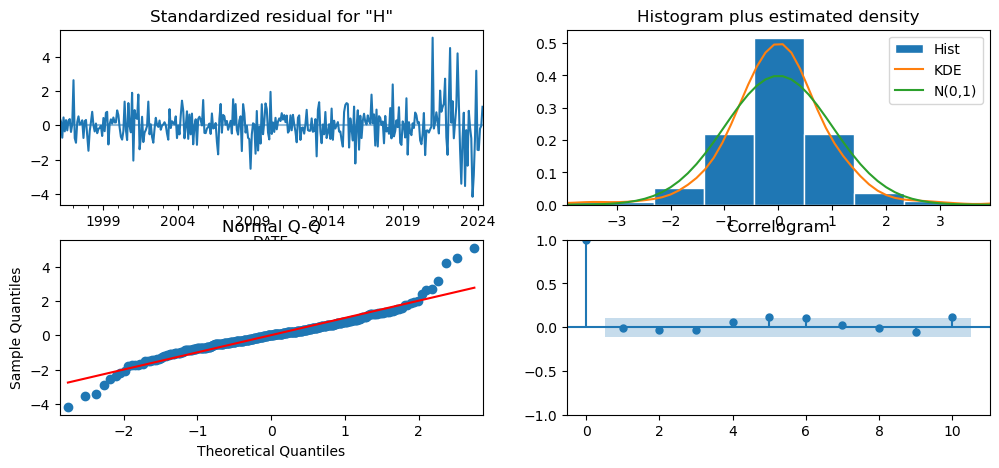

In [51]:
full_arima_train.plot_diagnostics(figsize=(12, 5));

#### Comments on the residual diagnostics for ARIMA(1,1,2) as follows:

 * *Beginning from the top right hand corner, it can be noticed that the standardized residuals are stationary. The residuals can be said to follow i.i.d sequence with a zero mean. There are few outliers with few exceeding standard deviation of 3.*

 * *Top right hand corner indicates that the residuals are Gaussian (normally distributed or marginally normal).*

* *The buttom left shows a plot of the theoritical quantile against the empirical quantile (Q-Q plot) - confirming once again that residuals are pretty normal.*

 * *The correlogram on the buttom right shows the lack of evidence of autocorrelation in the residuals (randomness of the residuals synonimous to a white noise process). The above residual diagnostics are pretty good.*







 *Next, we proceed to make predictions/forecast using our fitted ARIMA(1,1,2) model*


In [52]:
arima_forecast_1_2 = full_arima_train.get_forecast(steps=12)
y_hat = arima_forecast_1_2.predicted_mean
pred_conf_1_2 = arima_forecast_1_2.conf_int(alpha=0.05)
pred_conf_1_2["y_hat"] = y_hat

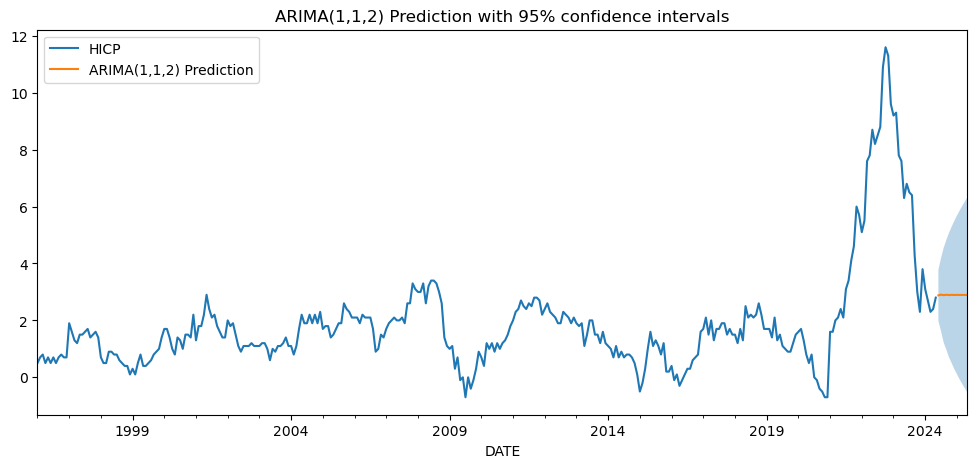

In [53]:
df["HICP"].plot(legend = True, figsize=(12,5))
pred_conf_1_2["y_hat"].plot(legend=True, label="ARIMA(1,1,2) Prediction", title = "ARIMA(1,1,2) Prediction with 95% confidence intervals");
plt.fill_between(pred_conf_1_2.index, pred_conf_1_2['lower HICP'], pred_conf_1_2['upper HICP'], alpha=0.3, label='Confidence Interval');

#### ARIMA (1,1,12) forecast
 *Similarly, we proceed to make predictions/forecast using our fitted ARIMA(1,1,12) model*

In [54]:
full_arima_train_12 = ARIMA(df["HICP"], order=(1,1,12)).fit()


In [55]:
arima_forecast_12 = full_arima_train_12.get_forecast(steps=12)
y_hat_12 = arima_forecast_12.predicted_mean
pred_conf_12 = arima_forecast_12.conf_int(alpha=0.05)
pred_conf_12["y_hat_12"] = y_hat_12

#### ARIMA(1,1,12) Residual diagnostics for the trained model

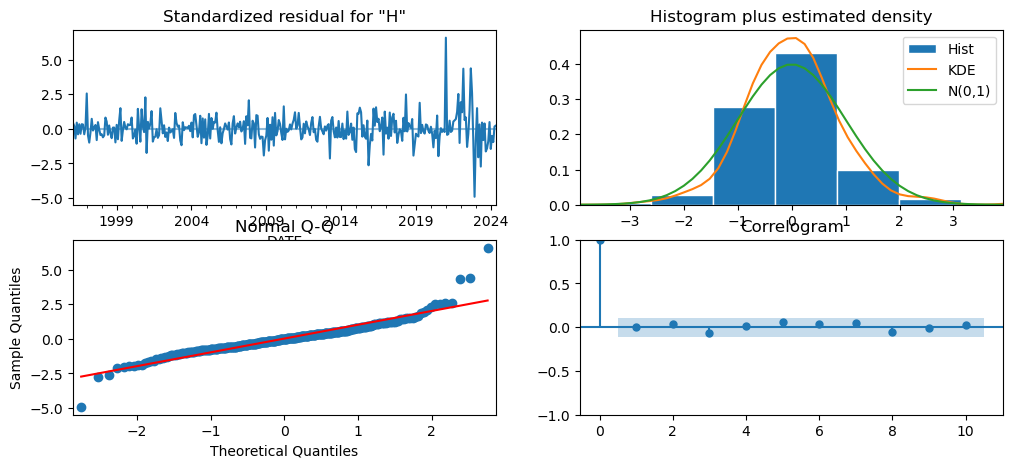

In [56]:
full_arima_train_12.plot_diagnostics(figsize=(12, 5));

 *It can be observed from the above residual diagnostics that the residuals appears to follow a white noise stationary process. The Q-Q plots also shows residuals follows a normal distribution (also the density plot) and finally correlogram displays the absence of serial correlation.*

##### *In the below, the actual plot including the forecasted values is displayed*

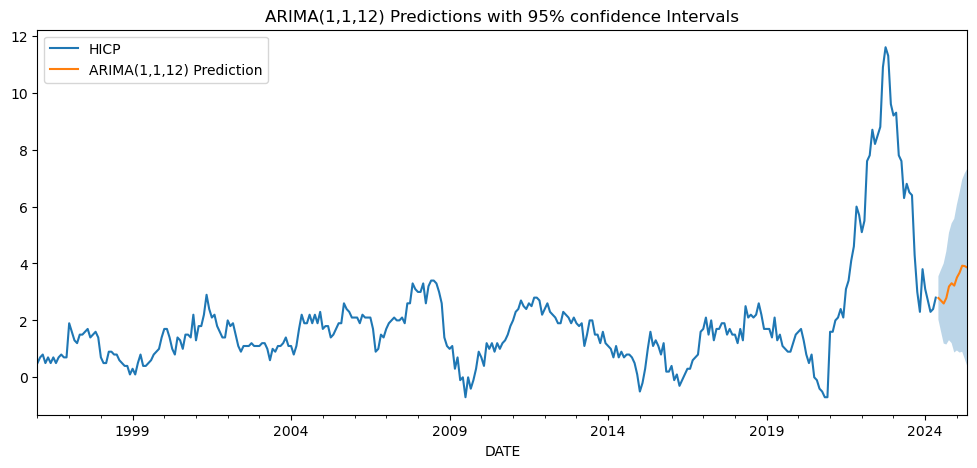

In [57]:

df["HICP"].plot(legend = True, figsize=(12,5))
pred_conf_12["y_hat_12"].plot(legend=True, label="ARIMA(1,1,12) Prediction", title = "ARIMA(1,1,12) Predictions with 95% confidence Intervals");
plt.fill_between(pred_conf_12.index, pred_conf_12['lower HICP'],pred_conf_12['upper HICP'], alpha=0.3, label='Confidence Interval');

#### Comparing future forecasted values for the two model predictions: ARIMA(1,1,2) versus ARIMA(1,1,12)

In [58]:
print("Inflation forecast for the next 12 months:")
pd.concat([pred_conf_1_2["y_hat"],pred_conf_12["y_hat_12"]], axis=1).rename(columns={"y_hat": "ARIMA(1,1,2)", "y_hat_12": "ARIMA(1,1,12)"})


Inflation forecast for the next 12 months:


,"ARIMA(1,1,2)","ARIMA(1,1,12)"
2024-06-30,2.879885,2.787118
2024-07-31,2.905231,2.691401
2024-08-31,2.886966,2.594092
2024-09-30,2.900128,2.788199
2024-10-31,2.890643,3.191029
2024-11-30,2.897479,3.305341
2024-12-31,2.892553,3.222410
2025-01-31,2.896102,3.505788
2025-02-28,2.893545,3.676376
2025-03-31,2.895388,3.921463


*The above depicts the values for the two ARIMA model predictions for the next 12 months.* 

